<a href="https://colab.research.google.com/github/dbssn/DMML2019_Team_Microsoft/blob/master/code/3_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports

In [0]:
# Load dataset
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')
df = pd.read_csv("https://drive.switch.ch/index.php/s/Gs1wqzxkNeCppeC/download")

# 1. Preprocessing

Some features such as "Inspection ID", "DBA Name" are not too useful when it comes to predicting the outcome of the inspection. Therefore, those columns are dropped.

In [5]:
# Drop columns that are not useful
df = df.drop(["Inspection ID", "DBA Name", "License #", "Address", "Zip", "Inspection Date", "Violations", "ApproxCreationDate"], axis = 1)
df.sample(1)

,Facility Type,Risk,Inspection Type,Results,Latitude,Longitude,Year,Month,Weekday,LenViol,TMAX,MeanMaxTemp3Days,DaysInBusiness
182,restaurant,Risk 1 (High),canvass,Pass,41.886708,-87.634319,2018,5,2,584,28.3,23.9,2959.0


### 1.1 Standardization

The first step is to normalize the numerical features :

*   Latitude
*   Longitude
*   LenViol
*   TMAX
*   MeanMaxTemp3Days
*   DaysInBusiness


In [6]:
df_prep = df[["Latitude", "Longitude", "LenViol", "TMAX", "MeanMaxTemp3Days", "DaysInBusiness", "Facility Type", "Risk", "Inspection Type", "Year", "Month", "Weekday", "Results"]]
df_prep.sample(1)


,Latitude,Longitude,LenViol,TMAX,MeanMaxTemp3Days,DaysInBusiness,Facility Type,Risk,Inspection Type,Year,Month,Weekday,Results
25403,41.726723,-87.550943,1759,22.2,19.833333,338.0,restaurant,Risk 1 (High),canvass,2014,9,3,Fail


In [7]:
# Standardization
from sklearn.preprocessing import StandardScaler
standardize = StandardScaler()
standardize.fit(df_prep.iloc[:, :6])
df_prep.iloc[:, :6] = standardize.transform(df_prep.iloc[:, :6])
df_prep.sample(1)

,Latitude,Longitude,LenViol,TMAX,MeanMaxTemp3Days,DaysInBusiness,Facility Type,Risk,Inspection Type,Year,Month,Weekday,Results
80786,-1.109214,-2.0867,1.476316,0.459289,0.650541,0.94589,grocery store,Risk 1 (High),complaint,2012,5,3,Fail


### 1.2 Encoding

The following features need to be encoded :

*   Facility Type
*   Risk
*   Inspection Type
*   Month
*   Weekday


In [0]:
# Encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# One hot encoding
one_hot = OneHotEncoder(categories="auto")
cat_to_onehot = pd.DataFrame(one_hot.fit_transform(df_prep[["Facility Type", "Risk", "Inspection Type", "Month", "Weekday"]]).toarray())

# Generate X
X = df_prep[["Latitude", "Longitude", "LenViol", "TMAX", "MeanMaxTemp3Days", "DaysInBusiness"]]
X = pd.concat([X, cat_to_onehot], axis=1)

# Generate y
lab_encoder = LabelEncoder()
Y = pd.DataFrame(lab_encoder.fit_transform(df_prep["Results"]))

In [13]:
X.sample(1)

,Latitude,Longitude,LenViol,TMAX,MeanMaxTemp3Days,DaysInBusiness,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
106061,0.447412,-1.278772,0.741898,-0.981533,-0.211545,-1.190353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2. Prediction

### 2.1 Base rate

In [14]:
# The base rest is defined as : size(most frequent class)/size(dataset)
failCount = df[df["Results"] == "Fail"].shape[0]
passCount = df[df["Results"] == "Pass"].shape[0]

if passCount > failCount :
  print("The most frequent class is " + "'Pass' (" + str(passCount) + ") VS 'Fail' (" + str(failCount)+ ").")
else :
   print("The most frequent class is " + "'Fail' (" + str(failCount) + ") VS 'Pass' (" + str(passCount)+ ").")

The most frequent class is 'Pass' (92447) VS 'Fail' (30148).


In [15]:
# Base rate
br = max(passCount, failCount)/(passCount + failCount)

print("The base rate is : " + str(round(br,3)))

The base rate is : 0.754


### 2.2 Balance dataset

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

Y=Y.rename(columns={0:"Results"})
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
down_sample=pd.concat([X_train,Y_train],axis=1)
pa=down_sample[down_sample["Results"]==1]
fa=down_sample[down_sample["Results"]==0]
pa=resample(pa, n_samples=len(fa.index), random_state=0)
concat=pa.append(fa,ignore_index=True)
X_train=concat.drop(["Results"],axis=1)
Y_train=concat["Results"]

print(X_train.shape)
print(X_test.shape)
print(Y_train.value_counts())

(48230, 65)
(24519, 65)
1    24115
0    24115
Name: Results, dtype: int64


In [17]:
# Because the name of the column will disappear after one-hot encoding, we rename the dataframe
X.columns=['Latitude','Longitude','LenViol','TMAX', 'MeanMaxTemp3Days','DaysInBusiness','bakery', 'catering','childrens services facility',
'daycare (2 - 6 years)', 'daycare (under 2 years)','daycare above and under 2 years', 'daycare combo 1586','gas station', 'golden diner',
'grocery store', 'hospital','liquor', 'long term care', 'mobile food dispenser','mobile food preparer', 'restaurant', 'school',
'shared kitchen user (long term)', 'special event', 'tavern','wholesale','Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)','canvass',
'canvass re-inspection', 'complaint','complaint re-inspection', 'complaint-fire', 'consultation','license', 'license re-inspection',
'license-task force','recent inspection', 'short form complaint','short form fire-complaint', 'suspected food poisoning',
'suspected food poisoning re-inspection', 'tag removal','task force liquor 1475',
"m1","m2","m3","m4","m5","m6","m7","m8","m9","m10","m11","m12","d0","d1","d2","d3","d4","d5","d6"]
print(X.sample(1))

        Latitude  Longitude   LenViol      TMAX  ...   d3   d4   d5   d6
115649 -1.867875   1.212744 -0.100178  1.322056  ...  0.0  1.0  0.0  0.0

[1 rows x 65 columns]


### 2.3 Feature selection using Randomforest

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

clf = RandomForestClassifier()
clf = clf.fit(X,Y)
thre=0.008
model = SelectFromModel(clf,prefit=True,threshold=thre)
x_select_ran = pd.DataFrame(model.transform(X))
x_select_ran.shape

(122595, 12)

### 2.4 Dimension reduction using PCA

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=14, svd_solver='auto')
pca.fit(X)
x_select_pca=pd.DataFrame(pca.transform(X))
print(round(sum(pca.explained_variance_ratio_),3))
print(x_select_pca.shape)

0.853
(122595, 14)


### 2.5 Compare the accuracy score between algorithms

In [0]:
from sklearn.svm import SVC
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb
import numpy as np
from sklearn.model_selection import cross_val_score,KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

kf = KFold(n_splits=5, random_state=None, shuffle=True)
out=[]

def gbc(x,y):
    clf = GradientBoostingClassifier()
    scores = cross_val_score(clf,x,y,cv=kf)
    out.append(round(scores.mean(),3))
    
def ada(x,y):
    clf = AdaBoostClassifier()
    scores = cross_val_score(clf,x,y,cv=kf)
    out.append(round(scores.mean(),3))
    
def qda(x,y):
    clf=QuadraticDiscriminantAnalysis()
    scores = cross_val_score(clf,x,y,cv=kf)
    out.append(round(scores.mean(),3))
    
def mlp(x,y):
    mlp=MLPClassifier()
    scores = cross_val_score(mlp,x,y,cv=kf)
    out.append(round(scores.mean(),3))
    
def bayes(x,y):
    clf = GaussianNB()
    scores = cross_val_score(clf,x,y, cv=kf)
    out.append(round(scores.mean(),3))
    
def knn(x,y):
    neigh = KNeighborsClassifier()
    scores = cross_val_score(neigh,x,y, cv=kf)
    out.append(round(scores.mean(),3))
    
def logistic(x,y):
    classifier = LogisticRegression()
    scores = cross_val_score(classifier,x,y, cv=kf)
    out.append(round(scores.mean(),3))
    
def forest(x,y):
    forest = RandomForestClassifier()
    scores = cross_val_score(forest,x,y, cv=kf)
    out.append(round(scores.mean(),3))
    
def xg(x,y):
    x=np.array(x)
    xgbc=xgb.XGBClassifier()
    scores = cross_val_score(xgbc, x,y, cv=kf)
    out.append(round(scores.mean(),3))
    
def tr(x,y):
    tre = tree.DecisionTreeClassifier()
    scores = cross_val_score(tre,x,y, cv=kf)
    out.append(round(scores.mean(),3))
    
def sv(x,y):
    clf = SVC()
    scores = cross_val_score(clf,x,y, cv=kf)
    out.append(round(scores.mean(),3))
    
def pipe(x,y):
    gbc(x,y)
    ada(x,y)
    qda(x,y)
    mlp(x,y)
    bayes(x,y)
    knn(x,y)
    logistic(x,y)
    forest(x,y)
    xg(x,y)
    tr(x,y)
    sv(x,y)

pipe(X,Y)
pipe(x_select_pca,Y)
pipe(x_select_ran,Y)

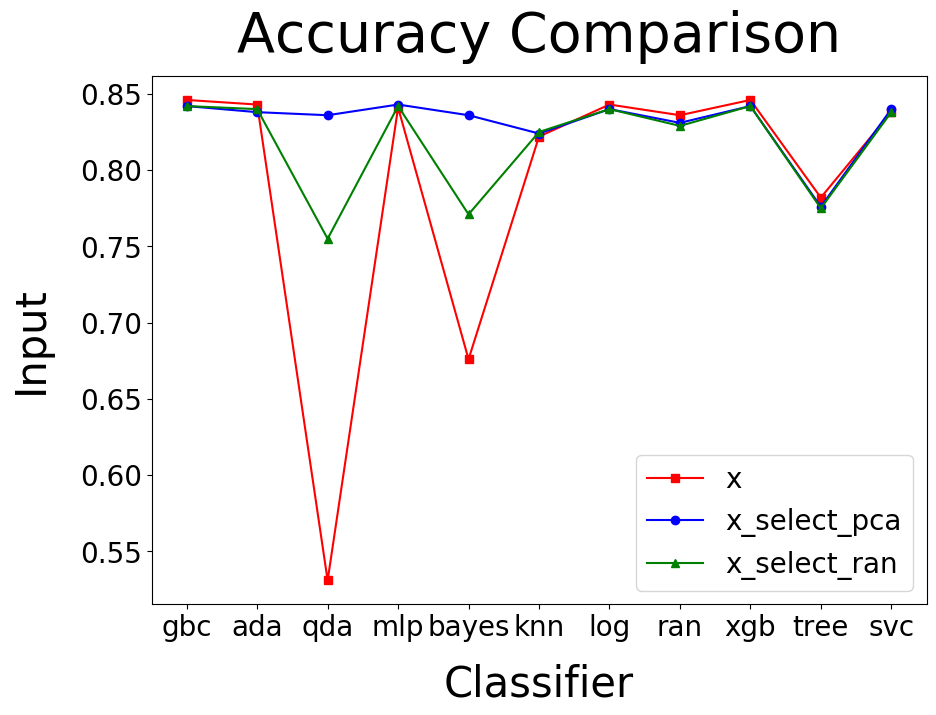

In [21]:
# Plot the accuracy comparison
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

xticks=["gbc","ada","qda","mlp","bayes","knn","log","ran","xgb","tree","svc"]
x_acc=out[:11]
x_select1_acc=out[11:22]
x_select2_acc=out[22:]
plt.figure(figsize=(10,7),dpi=100,linewidth = 2)
plt.plot(xticks,x_acc,'s-',color = 'r', label="x")
plt.plot(xticks,x_select1_acc,'o-',color = 'b', label="x_select_pca")
plt.plot(xticks,x_select2_acc,'^-',color = 'g', label="x_select_ran")
plt.title("Accuracy Comparison", x=0.5, y=1.03,fontsize=40)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Classifier", fontsize=30, labelpad = 15)
plt.ylabel("Input", fontsize=30, labelpad = 20)
plt.legend(loc = "best", fontsize=20)
plt.show()

### 2.5 Grid search for GradientBoosting, KNN, LogisticR, DecisionT, MLP, Xgboost,

In [22]:
#1. Grid search for GradientBoosting (We found the important hyper parameters based on the API documents and we start from default setting then try higher or lower number.)
from sklearn.model_selection import GridSearchCV

model=GradientBoostingClassifier()
param_grid = {'learning_rate':[0.1,0.05,0.2], 'n_estimators':[50,100,200],"max_depth":[2,3,4]}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(round(grid_result.best_score_,3))

{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 200}
0.843


In [23]:
#2. Grid search for GradientBoosting (We found 0.2 for learning rate is the best so we tried bigger number, so does n_estimators.)

model=GradientBoostingClassifier()
param_grid = {'learning_rate':[0.3,0.2], 'n_estimators':[300,200],"max_depth":[2,3,4]}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(round(grid_result.best_score_,3))

{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200}
0.844


In [24]:
#3. Grid search for GradientBoostingClassifier (We searched the learning rate around 0.2 and n_estimators around 200. Futhermore, we tried higher max_depth.)

model=GradientBoostingClassifier()
param_grid = {'learning_rate':[0.2,0.25,0.15], 'n_estimators':[200,250,150],"max_depth":[4,5,6]}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(round(grid_result.best_score_,3))

{'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 250}
0.844


In [25]:
#1. Grid search for KNeighborsClassifier (We found the important hyper parameters based on the API documents and we start from default setting then try higher or lower number.)

model=KNeighborsClassifier()
param_grid = {'n_neighbors':[4,5,6], 'weights':["uniform","distance"],"p":[1,2]}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(round(grid_result.best_score_,3))

{'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
0.829


In [26]:
#2. Grid search for KNeighborsClassifier (We tried to find larger n_neighbors)

model=KNeighborsClassifier(p=1,weights="distance")
param_grid = {'n_neighbors':[6,7,8]}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(round(grid_result.best_score_,3))

{'n_neighbors': 8}
0.833


In [27]:
#1. Grid search for DecisionTreeClassifier (We found the important hyper parameters based on the API documents and we start from default setting then try higher or lower number.)

model=tree.DecisionTreeClassifier()
param_grid = {'criterion':["gini","entropy"], 'min_samples_leaf':[1,2],"min_samples_split":[2,3]}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(round(grid_result.best_score_,3))

{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2}
0.78


In [28]:
#1. Grid search for LogisticRegression (We found the important hyper parameters based on the API documents and we start from default setting then try higher or lower number.)

model=LogisticRegression(solver="saga")
param_grid = {'penalty':["l1","l2"], 'tol':[1e-4,1e-3,1e-5],"C":[1,2]}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(grid_result.best_score_)

{'C': 1, 'penalty': 'l2', 'tol': 0.001}
0.8395040580774094


In [29]:
#2. Grid search for LogisticRegression (We tried to find smaller tol)

model=LogisticRegression(penalty="l1",solver="saga")
param_grid = {'tol':[1e-3,1e-2],"C":[1,1.5]}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(round(grid_result.best_score_,3))

{'C': 1.5, 'tol': 0.001}
0.839


In [30]:
#3. Grid search for LogisticRegression (We tried to find smaller tol)

model=LogisticRegression(penalty="l1",solver="saga",C=1.5)
param_grid = {'tol':[0.1,1e-2]}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(round(grid_result.best_score_,3))

{'tol': 0.01}
0.839


In [31]:
#1. Grid search for MLPClassifier (We found the important hyper parameters based on the API documents and we start from default setting then try higher or lower number.)

model=MLPClassifier()
param_grid = {"hidden_layer_sizes":((200,),(100,),(50,))}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(round(grid_result.best_score_,3))

{'hidden_layer_sizes': (50,)}
0.842


In [32]:
#2. Grid search for MLPClassifier (We searched layer_sizes around 100.)

model=MLPClassifier()
param_grid = {"hidden_layer_sizes":((75,),(100,),(150,))}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(round(grid_result.best_score_,3))

{'hidden_layer_sizes': (150,)}
0.842


In [33]:
#1. Grid search for XGBClassifier (We found the important hyper parameters based on the API documents and we start from default setting then try higher or lower number.)

model=xgb.XGBClassifier()
param_grid = {'eta':[0.2,0.3,0.4], 'max_depth':[6,7,5],"gamma":[0,10,100]}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(round(grid_result.best_score_,3))

{'eta': 0.2, 'gamma': 0, 'max_depth': 7}
0.844


In [34]:
#2. Grid search for XGBClassifier (We tried lower eta and higher max_depth.)

model=xgb.XGBClassifier()
param_grid = {'eta':[0.2,0.1], 'max_depth':[7,8,9]}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(round(grid_result.best_score_,3))

{'eta': 0.2, 'max_depth': 7}
0.845


In [35]:
#3. Grid search for XGBClassifier (We tried higher max_depth.)

model=xgb.XGBClassifier()
param_grid = {'max_depth':[9,10,11]}
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=kf,scoring="accuracy")
grid_result = grid.fit(x_select_ran,Y)
print(grid_result.best_params_)
print(round(grid_result.best_score_,3))

{'max_depth': 9}
0.844


###2.6 To show the important variables

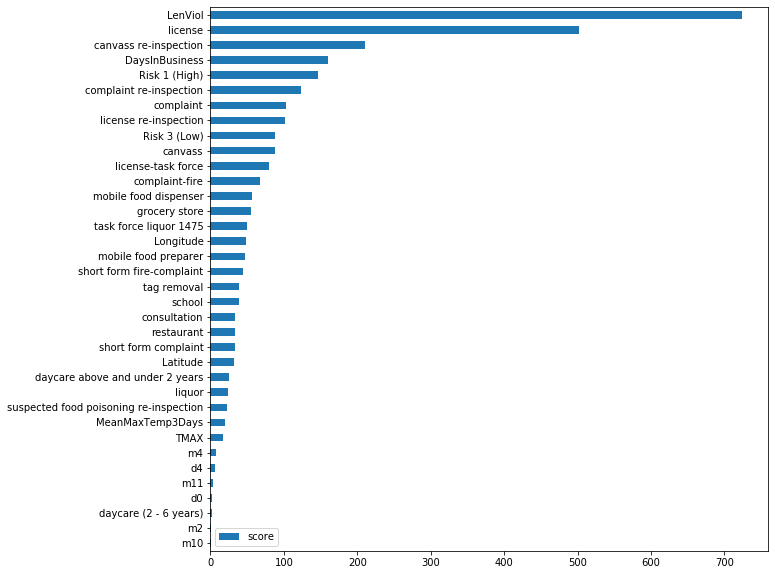

In [36]:
model=xgb.XGBClassifier(max_depth=9)
model.fit(X,Y)
feature_important=model.get_booster().get_score(importance_type="gain")
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind="barh",figsize=(10,10))

### 2.7 Voting ensemble


In [37]:
# We chose the best 3 classifiers into voting the gragh before.
# We used hyper parameters we found in grid search for the 3 classifiers.

def vote(x,y):
    clf1 = xgb.XGBClassifier(max_depth=9)
    clf2 = GradientBoostingClassifier(learning_rate=0.15,max_depth=5,n_estimators=200)
    clf3 = MLPClassifier(hidden_layer_sizes = (75,))
    eclf = VotingClassifier(estimators=[('1', clf1), ('2', clf2), ('3', clf3)])
    scores = cross_val_score(eclf,x,y,cv=kf)
    print(round(scores.mean(),3))

vote(X,Y)
vote(x_select_pca,Y)
vote(x_select_ran,Y)

0.85
0.845
0.845


###2.8 Show the confusion matrix and other scores

The f1 score is: 0.858
The recall score is: 0.804
The precision score is: 0.92



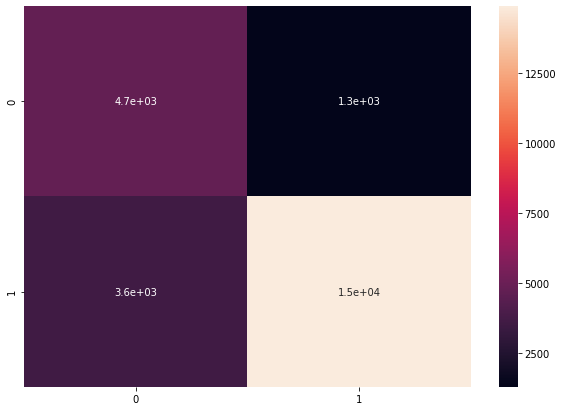

In [38]:
#Plot the confusion matrix and print the other scores.
#We used x_select_ran rather than X because it is much faster without losing a lot accuracy.

from sklearn.metrics import confusion_matrix,f1_score,recall_score,precision_score,average_precision_score
import seaborn as sn

clf1 = xgb.XGBClassifier(max_depth=9)
clf2 = GradientBoostingClassifier(learning_rate=0.15,max_depth=5,n_estimators=200)
clf3 = MLPClassifier(hidden_layer_sizes = (75,))
classifier = VotingClassifier(estimators=[('1', clf1), ('2', clf2), ('3', clf3)]).fit(X_train, Y_train)
Y_pred=classifier.predict(X_test)
matrix=confusion_matrix(Y_test, Y_pred)
plt.figure(figsize = (10,7))
sn.heatmap(matrix, annot=True)

print("The f1 score is: "+str(round(f1_score(Y_test, Y_pred),3)))
print("The recall score is: "+str(round(recall_score(Y_test, Y_pred),3)))
print("The precision score is: "+str(round(precision_score(Y_test, Y_pred),3))+"\n")

In [46]:
from sklearn.metrics import accuracy_score
print("The accuracy is: "+str(round(accuracy_score(Y_test, Y_pred),3)))

The accuracy is: 0.8
